In [1]:
import numpy as np
import sys 
import os
import matplotlib.pyplot as plt
#from utils import *
import copy
#import models
import cv2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
#import skimage.io as io
#import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.backend.tensorflow_backend as K

Using TensorFlow backend.


In [15]:
img_width = 96
img_height = 96
img_depth = 24

label_dir_pre = '/storage/filament/result/cluster_3d/40Mpc/label/'
img_dir_pre = '/storage/filament/result/cluster_3d/40Mpc/density_smooting_plot_5/'

box_list = ['box01/']
tmp_img = []
tmp_label = []
aug_list = [0,90,180,270]

data_list = []

for box_num in box_list:
    for sub_num in os.listdir(label_dir_pre + box_num):
        peak_list = os.listdir(label_dir_pre + box_num + sub_num + '/')
        for peak_num in peak_list:
            label_dir = label_dir_pre + box_num + sub_num + '/' + peak_num + '/whole/'
            img_dir = img_dir_pre + box_num + sub_num + '/' + peak_num + '/'

            for aug_dir in aug_list:
                os.chdir(label_dir+str(aug_dir)+'/')
                for nn,_ in enumerate(os.listdir(label_dir + str(aug_dir) + '/')):
                    tmp_label.append(cv2.resize(cv2.imread(label_dir + str(aug_dir) + '/' + str(nn) + '.png',cv2.IMREAD_GRAYSCALE),(img_width,img_height)))
                data_name = str("box_num " + str(box_num) + " sub_box " + str(sub_num) + " peak_num " + str(peak_num) + " aug_dir " + str(aug_dir))
                data_list.append(data_name)
                for nn,_ in enumerate(os.listdir(label_dir + 'z/'+ str(aug_dir) + '/')):
                    tmp_label.append(cv2.resize(cv2.imread(label_dir + 'z/'+ str(aug_dir) + '/'+ str(nn) + '.png',cv2.IMREAD_GRAYSCALE),(img_width,img_height)))
                data_name = str("box_num " + str(box_num) + " sub_box " + str(sub_num) + " peak_num " + str(peak_num) + " aug_dir " + str(aug_dir) + "with z")
                data_list.append(data_name)
                    
                    
                os.chdir(img_dir+str(aug_dir)+'/')
                for nn,_ in enumerate(os.listdir(img_dir + str(aug_dir) + '/')):
                    tmp_img.append(cv2.resize(cv2.imread(img_dir + str(aug_dir) + '/' + str(nn) + '.png',cv2.IMREAD_GRAYSCALE),(img_width,img_height)))
                for nn,_ in enumerate(os.listdir(img_dir + 'z/'+ str(aug_dir) + '/')):
                    tmp_img.append(cv2.resize(cv2.imread(img_dir + 'z/'+ str(aug_dir) + '/' + str(nn) + '.png',cv2.IMREAD_GRAYSCALE),(img_width,img_height)))


In [16]:
label_file = np.array(tmp_label)/255.
img_file = np.array(tmp_img)

length = label_file.shape[0]

In [36]:
img_file = img_file.reshape([len(data_list),96,96,96])
label_file = label_file.reshape([len(data_list),96,96,96])

In [37]:
img_train = []
label_train = []
img_val = []
label_val = []
for nn in range(len(data_list)):
    if nn == 7 or nn == 15 or nn == 23:
        img_val.append(img_file[nn,:,:,:])
        label_val.append(label_file[nn,:,:,:])
    else:
        img_train.append(img_file[nn,:,:,:])
        label_train.append(label_file[nn,:,:,:])

In [ ]:
img_train = np.array(img_train)
label_train = np.array(label_train)

img_val = np.array(img_val)
label_val = np.array(label_val)

In [40]:
img_train.shape,img_val.shape

((21, 96, 96, 96), (3, 96, 96, 96))

In [43]:
label_train = label_train.reshape([21*4,img_depth,img_height,img_width])
img_train = img_train.reshape([21*4,img_depth,img_height,img_width])

label_val = label_val.reshape([3*4,img_depth,img_height,img_width])
img_val = img_val.reshape([3*4,img_depth,img_height,img_width])


label_train = np.expand_dims(label_train,axis=-1)
img_train = np.expand_dims(img_train,axis=-1)

label_val = np.expand_dims(label_val,axis=-1)
img_val = np.expand_dims(img_val,axis=-1)

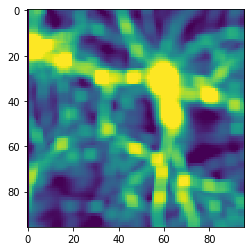

In [45]:
plt.imshow(img_val[0,0,:,:,0])

In [47]:
model = get_unet()
with K.tf.device('/gpu:0'):
    hist = model.fit(img_train, label_train, batch_size=3, epochs=100,validation_data=(img_val,label_val),shuffle=True )

#model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 84 samples, validate on 12 samples
Epoch 1/100
84/84 [==============================] - 155s 2s/step - loss: -0.1263 - dice_coef: 0.1263 - val_loss: -0.0717 - val_dice_coef: 0.0717
Epoch 2/100
84/84 [==============================] - 151s 2s/step - loss: -0.1460 - dice_coef: 0.1460 - val_loss: -0.0731 - val_dice_coef: 0.0731
Epoch 3/100
84/84 [==============================] - 152s 2s/step - loss: -0.1573 - dice_coef: 0.1573 - val_loss: -0.0748 - val_dice_coef: 0.0748
Epoch 4/100
84/84 [==============================] - 147s 2s/step - loss: -0.1679 - dice_coef: 0.1679 - val_loss: -0.0917 - val_dice_coef: 0.0917
Epoch 5/100
84/84 [==============================] - 151s 2s/step - loss: -0.1798 - dice_coef: 0.1798 - val_loss: -0.0979 - val_dice_coef: 0.0979
Epoch 6/100
84/84 [==============================] - 150s 2s/step - loss: -0.1969 - dice_coef: 0.1969 - val_loss: -0.1129 - val_dice_coef: 0.112

In [46]:
## model 3D Unet
def get_unet():
    
    n = 8
    
    inputs = Input((None, None,  None, 1))
    conv1 = Conv3D(n, (3, 3, 3), padding='same')(inputs)
    conv1 = BatchNormalization(axis=4)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv3D(n, (3, 3, 3), padding='same')(conv1)
    conv1 = BatchNormalization(axis=4)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv3D(n, (3, 3, 3), padding='same')(conv1)
    conv1 = BatchNormalization(axis=4)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = Conv3D(n, (3, 3, 3), padding='same', strides = (2 ,2, 2))(conv1)
    pool1 = BatchNormalization(axis=4)(pool1)
    pool1 = Activation('relu')(pool1)
#    pool1 = Dropout(0.25)(pool1)
#    pool1 = MaxPooling3D(pool_size=(2, 2, 1))(conv1)

    conv22 = concatenate([pool1, MaxPooling3D(pool_size=(2, 2, 2))(inputs)], axis=4)
    conv2 = Conv3D(2*n, (3, 3, 3), padding='same')(conv22)
    conv2 = BatchNormalization(axis=4)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv3D(2*n, (3, 3, 3), padding='same')(conv2)
    conv2 = BatchNormalization(axis=4)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv3D(2*n, (3, 3, 3), padding='same')(conv2)
    conv2 = BatchNormalization(axis=4)(conv2)
    conv2 = Activation('relu')(conv2)                           
    pool2 = Conv3D(2*n, (3, 3, 3), padding='same', strides = (2, 2, 2))(conv2)
    pool2 = BatchNormalization(axis=4)(pool2)
    pool2 = Activation('relu')(pool2)
#    pool2 = Dropout(0.25)(pool2)
#    pool2 = MaxPooling3D(pool_size=(2, 2, 1))(conv2)

    conv33 = concatenate([pool2, MaxPooling3D(pool_size=(2, 2, 2))(conv22)], axis=4)
    conv3 = Conv3D(4*n, (3, 3, 3), padding='same')(conv33)    
    conv3 = BatchNormalization(axis=4)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv3D(4*n, (3, 3, 3), padding='same')(conv3)    
    conv3 = BatchNormalization(axis=4)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv3D(4*n, (3, 3, 3), padding='same')(conv3)
    conv3 = BatchNormalization(axis=4)(conv3)
    conv3 = Activation('relu')(conv3)
#    conv3 = Conv3D(4*n, (3, 3, 3), padding='same')(conv3)
#    conv3 = BatchNormalization(axis=4)(conv3)
#    conv3 = Activation('relu')(conv3)
    pool3 = Conv3D(2*n, (3, 3, 3), padding='same', strides = (2, 2, 2))(conv3)
    pool3 = BatchNormalization(axis=4)(pool3)
    pool3 = Activation('relu')(pool3)
    
    
    conv44 = concatenate([pool3, MaxPooling3D(pool_size=(2, 2, 2))(conv33)], axis=4)
    conv4 = Conv3D(8*n, (3, 3, 3), padding='same')(conv44)    
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(8*n, (3, 3, 3), padding='same')(conv4)    
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(8*n, (3, 3, 3), padding='same')(concatenate([conv44, conv4], axis=4))
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(8*n, (3, 3, 3), padding='same')(conv4)    
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
#    conv3 = Dropout(0.5)(conv3)
#    pool3 = MaxPooling3D(pool_size=(2, 2, 1))(conv3)

#    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool3)
#    conv4 = BatchNormalization(axis=1)(conv4)
#    conv4 = Activation('relu')(conv4)
#    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)
#    conv4 = BatchNormalization(axis=1)(conv4)

    up5 = concatenate([Conv3DTranspose(2*n, (3, 3, 3), strides=(2, 2, 2), padding='same')(conv4), conv3], axis=4)
    conv5 = Conv3D(4*n, (3, 3, 3), padding='same')(up5)
    conv5 = BatchNormalization(axis=4)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv3D(4*n, (3, 3, 3), padding='same')(conv5)
    conv5 = BatchNormalization(axis=4)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv3D(4*n, (3, 3, 3), padding='same')(concatenate([up5, conv5], axis=4))
    conv5 = BatchNormalization(axis=4)(conv5)
    conv5 = Activation('relu')(conv5)
    
    up6 = concatenate([Conv3DTranspose(n, (3, 3, 3), strides=(2, 2, 2), padding='same')(conv5), conv2], axis=4)
    conv6 = Conv3D(2*n, (3, 3, 3), padding='same')(up6)
    conv6 = BatchNormalization(axis=4)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv3D(2*n, (3, 3, 3), padding='same')(conv6)
    conv6 = BatchNormalization(axis=4)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv3D(2*n, (3, 3, 3), padding='same')(concatenate([up6, conv6], axis=4))
    conv6 = BatchNormalization(axis=4)(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = concatenate([Conv3DTranspose(n, (3, 3, 3), strides=(2, 2, 2), padding='same')(conv6), conv1], axis=4)
    conv7 = Conv3D(n, (3, 3, 3), padding='same')(up7)
    conv7 = BatchNormalization(axis=4)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv3D(n, (3, 3, 3), padding='same')(conv7)
    conv7 = BatchNormalization(axis=4)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv3D(n, (3, 3, 3), padding='same')(concatenate([up7, conv7], axis=4))
    conv7 = BatchNormalization(axis=4)(conv7)
    conv7 = Activation('relu')(conv7)
 #   up6 = concatenate([Conv3DTranspose(16, (2, 2, 1), strides=(2, 2, 1), padding='same')(conv5), conv1], axis=4)
 #   conv6 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up6)
 #   conv6 = BatchNormalization(axis=1)(conv6)
 #   conv6 = Activation('relu')(conv6)
 #   conv6 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv6)
 #   conv6 = BatchNormalization(axis=1)(conv6)
 #   conv6 = Activation('relu')(conv6)
    
    conv8 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv7)
    
    model = Model(inputs=[inputs], outputs=[conv8])
    
    learning_rate = 1e-3
    decay_rate = learning_rate/300
    
    model.compile(optimizer=Adam(lr=learning_rate, decay=decay_rate), loss=dice_coef_loss, metrics=[dice_coef])
#   model.compile(optimizer=Adam(lr=1e-5), loss=losses.mean_squared_error, metrics=[dice_coef])

    return model



## loss function
smooth = 1e-7

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth * 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [48]:
model.save_weights('/storage/filament/result/cluster_3d/40Mpc/prediction/aug_xyz_shuffle/model.h5')

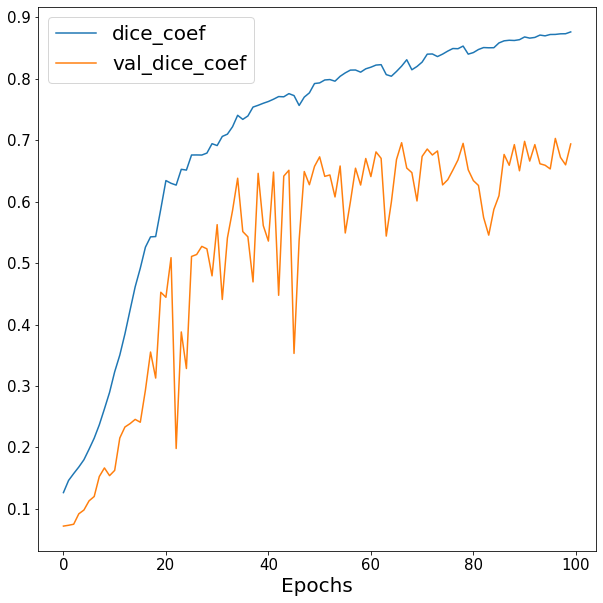

In [54]:
plt.figure(figsize=[10,10])
plt.plot(np.abs(hist.history['dice_coef']),label='dice_coef')
plt.plot(np.abs(hist.history['val_dice_coef']),label='val_dice_coef')
plt.legend(fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.ylabel('',fontsize=20)


plt.savefig('/storage/filament/result/cluster_3d/40Mpc/prediction/aug_xyz_shuffle/fig.png')

In [ ]:
test = model.predict(img_val)
#plt.contourf(test)

In [66]:
hist.history

(12, 24, 96, 96, 1)

<Figure size 720x720 with 0 Axes>

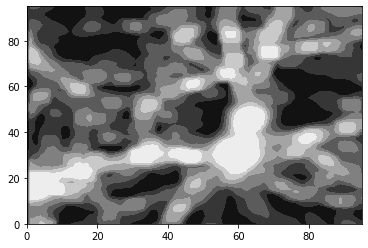

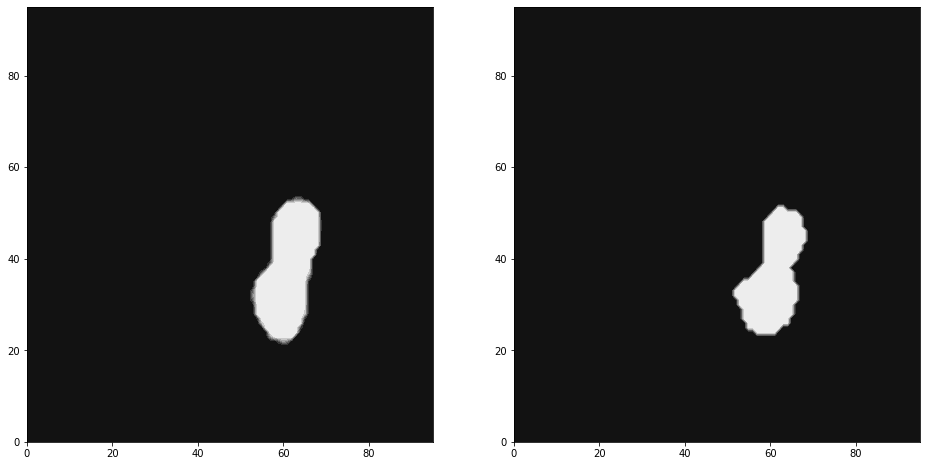

In [61]:
i = 0
j = 1
plt.figure(figsize=[10,10])
plt.show()
plt.contourf(img_val[i,j,:,:,0])
plt.figure(figsize=[16,8])
plt.subplot(121)
plt.contourf(test[i,j,:,:,0])
plt.gray()
plt.subplot(122)
plt.contourf(label_val[i,j,:,:,0])
plt.gray()

In [ ]:
i =1
j = 0
plt.contourf(test[i,j,:,:,0])

In [53]:
test.shape

(16, 24, 96, 96, 1)

In [67]:
data_list

['box_num box01/ sub_box subbox08 peak_num 0 aug_dir 0',
 'box_num box01/ sub_box subbox08 peak_num 0 aug_dir 0with z',
 'box_num box01/ sub_box subbox08 peak_num 0 aug_dir 90',
 'box_num box01/ sub_box subbox08 peak_num 0 aug_dir 90with z',
 'box_num box01/ sub_box subbox08 peak_num 0 aug_dir 180',
 'box_num box01/ sub_box subbox08 peak_num 0 aug_dir 180with z',
 'box_num box01/ sub_box subbox08 peak_num 0 aug_dir 270',
 'box_num box01/ sub_box subbox08 peak_num 0 aug_dir 270with z',
 'box_num box01/ sub_box subbox03 peak_num 0 aug_dir 0',
 'box_num box01/ sub_box subbox03 peak_num 0 aug_dir 0with z',
 'box_num box01/ sub_box subbox03 peak_num 0 aug_dir 90',
 'box_num box01/ sub_box subbox03 peak_num 0 aug_dir 90with z',
 'box_num box01/ sub_box subbox03 peak_num 0 aug_dir 180',
 'box_num box01/ sub_box subbox03 peak_num 0 aug_dir 180with z',
 'box_num box01/ sub_box subbox03 peak_num 0 aug_dir 270',
 'box_num box01/ sub_box subbox03 peak_num 0 aug_dir 270with z',
 'box_num box01/ sub

In [68]:
test_re = test.reshape([3,96,96,96])

In [70]:
#img_val = img_file[:16,:,:,:,:]
save_dir = '/storage/filament/result/cluster_3d/40Mpc/prediction/aug_xyz_shuffle/'
for i in range(test_re.shape[0]):
    if not os.path.isdir(save_dir + str(i) +'/'):
        os.makedirs(save_dir + str(i) +'/')
    os.chdir(save_dir + str(i) +'/')
    for j in range(test_re.shape[1]):
            plt.figure(figsize=[30,30])
            plt.imsave(str(j) +'.png',test_re[i,j,:,:],cmap='gray',dpi=300,format='png')


/home/ha/anaconda3/envs/research_filament/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [81]:
img_val.shape

(16, 24, 96, 96, 1)

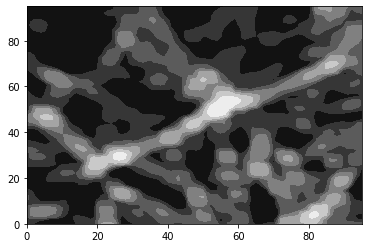

In [124]:
plt.contourf(img_val[0,0,:,:,0])

In [55]:
os.chdir('/storage/filament/result/cluster_3d/40Mpc/prediction/aug_xyz/pic/')
for i in range(16):
    for j in range(24):
        plt.figure(figsize=[30,30])
        plt.imsave('i_' + str(i) + ' j_' + str(j) +'.png',test[i,j,:,:,0],cmap='gray',dpi=300,format='png')



/home/ha/anaconda3/envs/research_filament/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [ ]:
K